## Sanity check on finetuned inference 

Note: **Rough Notebook rn - needs cleanup**

In [12]:
import pandas as pd
import evaluate
import json
from matplotlib import pyplot as plt

## Rouge Scores

### Helpers

In [3]:
rouge = evaluate.load('rouge')

def calculate_rouge_scores(df):
    base_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}
    ft_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}
    
    for _, row in df.iterrows():
        output = row['output']
        prediction_base = row['prediction_base'] if row['prediction_base'] is not None else ''
        prediction_ft = row['prediction_ft'] if row['prediction_ft'] is not None else ''
        
        # base model
        base_result = rouge.compute(predictions=[prediction_base], references=[output])
        base_scores['rouge1'].append(base_result['rouge1'])
        base_scores['rouge2'].append(base_result['rouge2'])
        base_scores['rougeL'].append(base_result['rougeL'])
        
        # fine-tuned model
        ft_result = rouge.compute(predictions=[prediction_ft], references=[output])
        ft_scores['rouge1'].append(ft_result['rouge1'])
        ft_scores['rouge2'].append(ft_result['rouge2'])
        ft_scores['rougeL'].append(ft_result['rougeL'])

    df['base_rouge1'] = base_scores['rouge1']
    df['base_rouge2'] = base_scores['rouge2']
    df['base_rougeL'] = base_scores['rougeL']
    df['ft_rouge1'] = ft_scores['rouge1']
    df['ft_rouge2'] = ft_scores['rouge2']
    df['ft_rougeL'] = ft_scores['rougeL']
    
    return df

# Function to visualize mean ROUGE scores as a bar plot
def visualize_mean_rouge_scores(df):
    rouge_types = ['rouge1', 'rouge2', 'rougeL']
    base_means = [df[f'base_{rouge}'].mean() for rouge in rouge_types]
    ft_means = [df[f'ft_{rouge}'].mean() for rouge in rouge_types]
    
    x = range(len(rouge_types))
    plt.figure(figsize=(8, 6))
    plt.bar(x, base_means, width=0.4, label='Base Model', align='center', color='#ff6666')
    plt.bar([i + 0.4 for i in x], ft_means, width=0.4, label='Fine-tuned Model', align='center', color='#00CCCC')
    plt.xticks([i + 0.2 for i in x], [r.upper() for r in rouge_types])
    plt.xlabel('ROUGE Metric')
    plt.ylabel('Mean ROUGE Score')
    plt.title('Mean ROUGE Scores of Model Prediction vs Actual Question based on Transcript Context')
    plt.legend()
    # plt.grid(True)
    # plt.savefig('mean_rouge_scores.png')
    plt.show()

def visualize_individual_rouge_scores(df):
    # create a single figure with three subplots
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    for i, rouge_type in enumerate(['rouge1', 'rouge2', 'rougeL']):
        ax[i].scatter(df[f'base_{rouge_type}'], df[f'ft_{rouge_type}'], alpha=0.6, c='#1f77b4')
        ax[i].plot([0, 1], [0, 1], 'r--')
        ax[i].set_xlim(-0.03, 0.8)
        ax[i].set_ylim(-0.03, 0.8)
        ax[i].set_xlabel('Base Model ROUGE Score')
        ax[i].set_ylabel('Fine-tuned Model ROUGE Score')
        ax[i].set_title(f'{rouge_type.upper()} Scores: Base vs. Fine-tuned')
        ax[i].grid(True)
    # plt.savefig('individual_rouge_scores.png')
    plt.show()

### Calculate ROUGE scores

In [4]:
in_file_ft = "../datasets/llm_outputs/finetuned_inference/processed/inference_oral_arg_context_test_100_lora_finetuned_llama_70B_4bit.jsonl"
in_file_base = "../datasets/llm_outputs/finetuned_inference/processed/inference_oral_arg_context_test_100_base_model_llama_70B_4bit.jsonl"

df_ft = pd.read_json(in_file_ft, lines=True)
df_base = pd.read_json(in_file_base, lines=True)

In [5]:
# df_ft.head()

In [6]:
# df_base.head()

In [7]:
df_merged = pd.merge(df_base, df_ft, on=['transcript_id', 'system_prompt', 'instruction', 'output', 'justice'], suffixes=['_base', '_ft'])

In [8]:
# df_merged.head()

In [9]:

df_merged = calculate_rouge_scores(df_merged)

In [10]:
# df_merged.head()

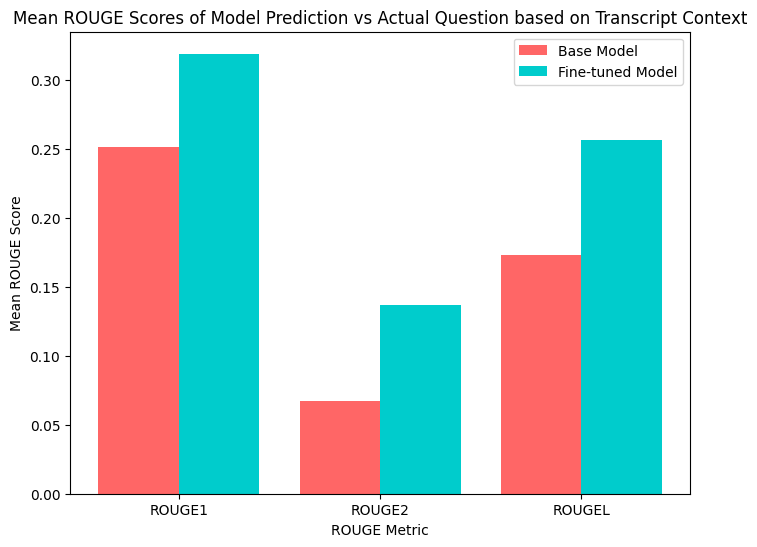

In [13]:
visualize_mean_rouge_scores(df_merged)

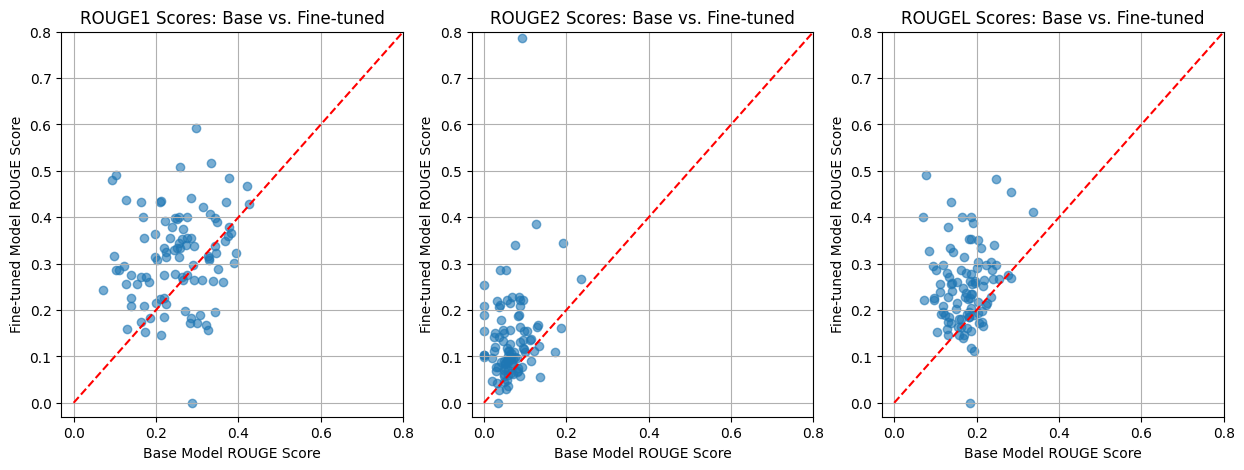

In [14]:
visualize_individual_rouge_scores(df_merged)

### Rouge Scores on Kylie's generated questions

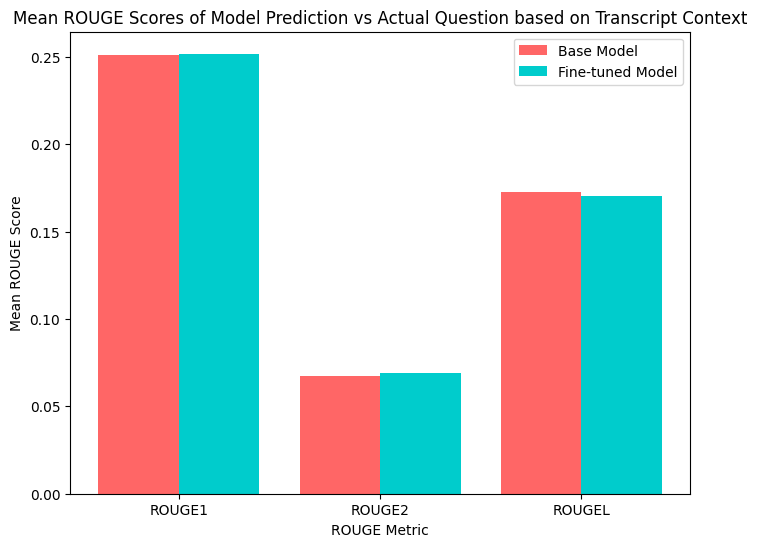

In [ ]:
in_file_ft = "../datasets/llm_outputs/finetuned_inference/processed/kylie_test_100_finetune_generated_questions.json"
in_file_base = "../datasets/llm_outputs/finetuned_inference/processed/inference_oral_arg_context_test_100_base_model_llama_70B_4bit.jsonl"

## Load base model predictions
df_base = pd.read_json(in_file_base, lines=True)

## Load Kylie's finetuned model predictions
with open(in_file_ft) as f:
    data = json.load(f)
for sample in data:
    sample['prediction'] = sample['response']['content']
    del sample['response']

df_ft = pd.DataFrame(data)

## Create merged dataframe
df_merged = pd.merge(df_base, df_ft, on=['transcript_id', 'system_prompt', 'instruction', 'output', 'justice'], suffixes=['_base', '_ft'])

## Calculate rouge scores
df_merged = calculate_rouge_scores(df_merged)

## Visualize mean rouge scores
visualize_mean_rouge_scores(df_merged)

## Manual Inspection

In [22]:
# in_file = "../datasets/llm_outputs/finetuned_inference/processed/Meta-Llama-3.1-8B-Instruct-bnb-4bit_inference_oral_arg_test_901.jsonl"
# in_file = "../datasets/llm_outputs/finetuned_inference/processed/Llama-3.3-70B-Instruct-bnb-4bit_inference_oral_arg_test_201.jsonl"
in_file = "../datasets/llm_outputs/finetuned_inference/processed/inference_oral_arg_context_test_100_lora_finetuned_llama_70B_4bit.jsonl"

df = pd.read_json(in_file, lines=True)

In [ ]:
# df.head()

In [ ]:
# df['instruction'][0].split('\n')

In [ ]:
# df['output'][0]

In [ ]:
# df['prediction'][0]

In [23]:
import json
import argparse
import pandas as pd
from rich.console import Console
from rich.table import Table
from rich.markdown import Markdown
import textwrap

def load_jsonl(file_path):
    """Load a JSONL file into a list of dictionaries."""
    with open(file_path, 'r', encoding='utf-8') as f:
        return [json.loads(line) for line in f]

def display_comparison(data):
    """Display instruction, output, and prediction for comparison."""
    console = Console()
    
    # for idx, entry in enumerate(data):
    for idx, entry in data.iterrows():
        print("#### CONTEXT: ")
        for t in entry['instruction'].split('\n'):
            wrapped_t = textwrap.fill(t, width=160)
            print(wrapped_t)
        table = Table(show_header=True, header_style="bold magenta")
        table.add_column("Field", style="bold")
        table.add_column("Text", style="italic")
        table.add_row("Ground Truth", entry.get('output', 'N/A'))
        table.add_row("Finetuned Llama 70B Prediction", entry.get('prediction', 'N/A'))
        console.print(table)
        
        console.print("\n" + "-" * 80 + "\n")

    
# data = pd.DataFrame(load_jsonl(in_file))

# display_comparison(data)


""" 
SYSTEM PROMPT:

"You are a Supreme Court Justice participating in oral arguments. Given a transcript excerpt and a Justice's name, 
generate the Justice's next question in response to the conversation history."
"""


' \nSYSTEM PROMPT:\n\n"You are a Supreme Court Justice participating in oral arguments. Given a transcript excerpt and a Justice\'s name, \ngenerate the Justice\'s next question in response to the conversation history."\n'

In [24]:
in_file_train = "../datasets/finetune/train.jsonl"
data_train = pd.DataFrame(load_jsonl(in_file_train))
train_tids = data_train['transcript_id'].unique()

data_test = pd.DataFrame(load_jsonl(in_file))
df_filtered = data_test[data_test['transcript_id'].apply(lambda x: x not in train_tids)]

In [ ]:
# df_filtered.info()

In [25]:
display_comparison(df_filtered[:2])

#### CONTEXT: 
<context>
<turn>Charles J. Cooper: --Your Honor, it -- it is certainly among the--</turn>
<turn>Justice Ruth Bader Ginsburg: It wouldn't be in California, Mr. Cooper, because that's not an issue, is it? In California, you can have same-sex couples
adopting a child.</turn>
<turn>Charles J. Cooper: --That's right, Your Honor. That is true. And -- but -- but, Your Honor, here's -- here's the point--</turn>
<turn>Justice Antonin Scalia: I -- it's true, but irrelevant. They're arguing for a nationwide rule which applies to States other than California, that every
State must allow marriage by same-sex couples. And so even though States that believe it is harmful -- and I take no position on whether it's harmful or not,
but it is certainly true that -- that there's no scientific answer to that question at this point in time.</turn>
<turn>Charles J. Cooper: --And -- and that, Your Honor, is the point I am trying to make, and it is the Respondents' responsibility to prove, under 

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Field                          ┃ Text                                                                           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Ground Truth                   │ Justice Elena Kagan: Well, suppose a State said, Mr. Cooper, suppose a State   │
│                                │ said that, Because we think that the focus of marriage really should be on     │
│                                │ procreation, we are not going to give marriage licenses anymore to any couple  │
│                                │ where both people are over the age of 55. Would that be constitutional?        │
│ Finetuned Llama 70B Prediction │ Justice Elena Kagan: Suppose a State made its anti-miscegenation law more      │
│                                │ equal, as well. Suppose the most equal the State could make it in its own eyes │
│                                │ was to say that it allowed everybody to marry somebody who was presumed to be  │
│                                │ of an inferior race. You know what? We'll let them marry somebody else who is  │
│                                │ presumed to be of an inferior race. Would that make it constitutional?         │
└────────────────────────────────┴────────────────────────────────────────────────────────────────────────────────┘

--------------------------------------------------------------------------------

#### CONTEXT: 
<context>
<turn>Justice Samuel A. Alito, Jr.: I still don't understand what you want to have take place for -- in practical -- in practical terms. You want this case
remanded to the district court and you think that after the case is -- we remand the case to the district court, there will be time to adopt a new map to be
used in the 2018 election?</turn>
<turn>Michael B. Kimberly: Your Honor, I -- I -- the -- the short answer to that question is that that is an issue for the district court to decide. It is, as I
say, not something that we have conceded, and I think it -- it's conceivable that the case could get back down to the district court in time for some form of
relief. Certainly, the district court could conclude that there isn't enough time and allow an election to take place under the map as it's drawn. It might look
for some sort of interim solution under 2 U.S.C. 2a(c).</turn>
<turn>Justice John G. Roberts, Jr.: What would that -- what would that --</turn>
<tur

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Field                          ┃ Text                                                                           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Ground Truth                   │ Justice Sonia Sotomayor: Now can you go through that trial without a ruling    │
│                                │ from us? And, if not, why not? Judge Niemeyer said that there were many open   │
│                                │ issues in this case, not the least of which was the motivation of the -- of    │
│                                │ the Governor and his committee for the change at issue. Would that obviate     │
│                                │ some of the merits questions that are before us if you don't prove that first  │
│                                │ prong? You have fairly strong evidence to -- to show that.                     │
│ Finetuned Llama 70B Prediction │ Justice Sonia Sotomayor: All right. So what's the harm if we just let it go to │
│                                │ the merits trial?                                                              │
└────────────────────────────────┴────────────────────────────────────────────────────────────────────────────────┘

--------------------------------------------------------------------------------